In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0802"
name_notebook = day + "-sh_1qm.ipynb"

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.exp_Z(1),
    n_layers = 25,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

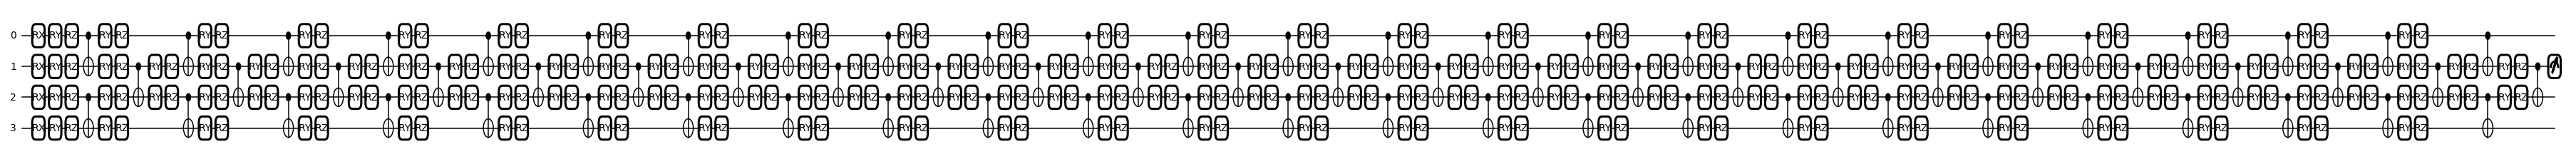

In [10]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [11]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [12]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0])]
layers += [quantum_layer()]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]

In [13]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
    keep_track_params=True,
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [14]:
print(model(input_data[0]).item())
print(model(input_data[1]).item())

0.4397516791058914
0.4397447280566661


In [15]:
import torch.optim as optim

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.5},
    num_epochs = 25,                
    batch_size = 32,
)

Epoch [0/25], Loss: 3.3016, Loss validation: 3.3231


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.0602, 	 target: -0.0662, 	 loss: 0.0897
	 Validation string, 	 i: 1; 	 prediction: -0.0602, 	 target: 0.2078, 	 loss: 1.2898
	 Validation string, 	 i: 2; 	 prediction: -0.0602, 	 target: -0.0342, 	 loss: 0.7619
Epoch [1/25], Loss: 2.0729, Loss validation: 1.1877, Time remaining: ~0.0h 20.0m 29s
	 Validation string, 	 i: 0; 	 prediction: 0.3950, 	 target: -0.0662, 	 loss: 6.9699
	 Validation string, 	 i: 1; 	 prediction: 0.3950, 	 target: 0.2078, 	 loss: 0.9003
	 Validation string, 	 i: 2; 	 prediction: 0.3950, 	 target: -0.0342, 	 loss: 12.5549
Epoch [2/25], Loss: 2.0238, Loss validation: 2.9915, Time remaining: ~0.0h 18.0m 34s
	 Validation string, 	 i: 0; 	 prediction: -0.0395, 	 target: -0.0662, 	 loss: 0.4024
	 Validation string, 	 i: 1; 	 prediction: -0.0395, 	 target: 0.2078, 	 loss: 1.1902
	 Validation string, 	 i: 2; 	 prediction: -0.0395, 	 target: -0.0342, 	 loss: 0.1567
Epoch [3/25], Loss: 1.9761, Loss validation: 1.1051, Time rem

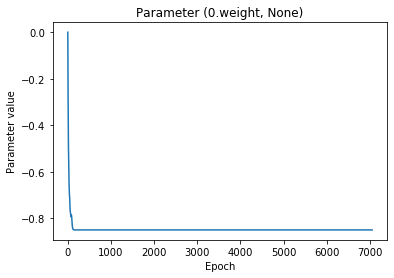

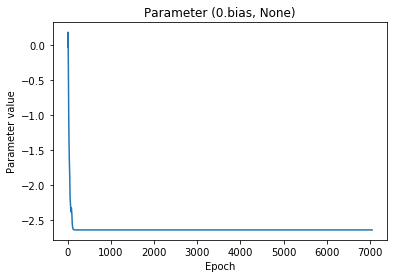

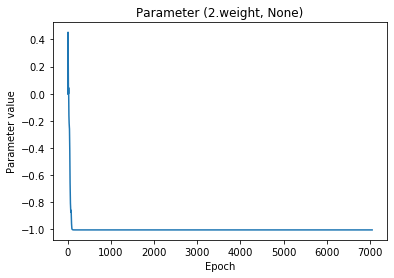

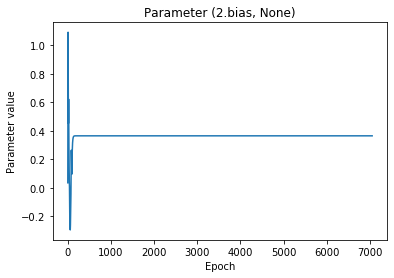

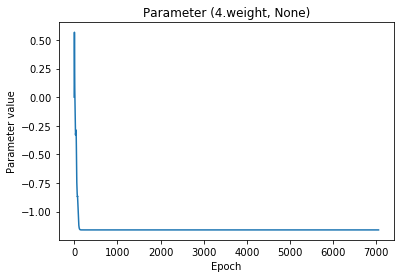

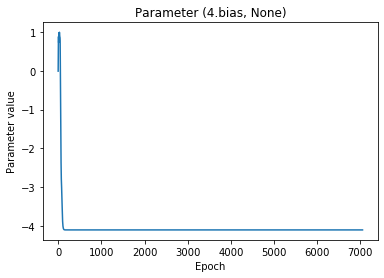

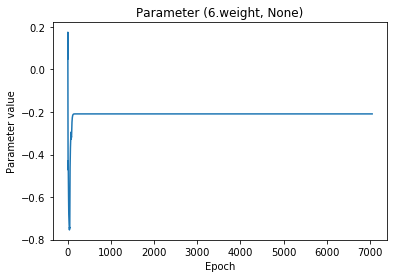

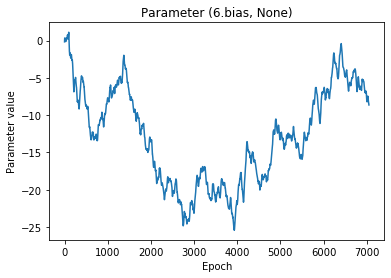

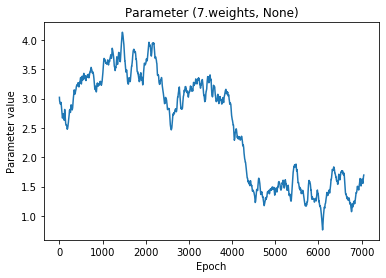

In [16]:
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer)

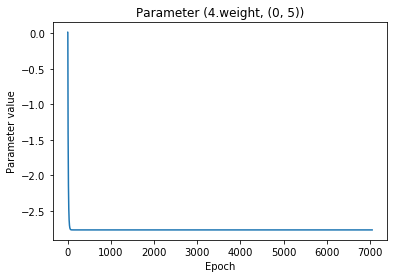

In [17]:
model.plot_parameter(layer='4.weight', index=(0,5))

In [18]:
model

Sequential(
  (0): Linear(in_features=76, out_features=52, bias=True)
  (1): ReLU()
  (2): Linear(in_features=52, out_features=28, bias=True)
  (3): ReLU()
  (4): Linear(in_features=28, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=4, bias=True)
  (7): <Quantum Torch Layer: func=circuit>
)

The file peptide-QML/checkpoints/0802/plots/0802-sh_1qm_losses_batches_1.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0802/plots/0802-sh_1qm_losses_batches_1.png


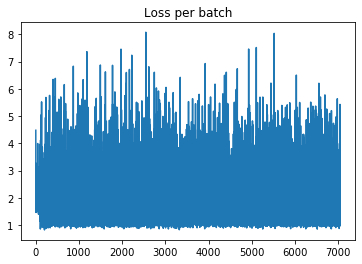

The file peptide-QML/checkpoints/0802/plots/0802-sh_1qm_losses_epoch_1.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0802/plots/0802-sh_1qm_losses_epoch_1.png


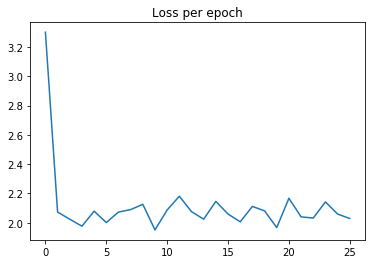

The file peptide-QML/checkpoints/0802/plots/0802-sh_1qm_losses_epoch_validation_1.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0802/plots/0802-sh_1qm_losses_epoch_validation_1.png


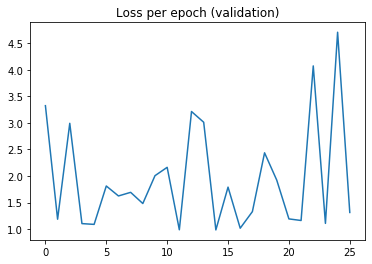

In [19]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

In [20]:
model.save_state_dict()

The file peptide-QML/checkpoints/0802/models/0802-sh_1qm_1.pth already exists, it will be replaced
Model saved as peptide-QML/checkpoints/0802/models/0802-sh_1qm_1.pth


In [21]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 083ab78] data trained model
 4 files changed, 0 insertions(+), 0 deletions(-)
 rewrite checkpoints/0802/models/0802-sh_1qm_1.pth (97%)
 rewrite checkpoints/0802/plots/0802-sh_1qm_losses_batches_1.png (99%)
 rewrite checkpoints/0802/plots/0802-sh_1qm_losses_epoch_1.png (99%)
 rewrite checkpoints/0802/plots/0802-sh_1qm_losses_epoch_validation_1.png (99%)
Enumerating objects: 19, done.
Counting objects: 100% (19/19), done.
Delta compression using up to 24 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 92.32 KiB | 8.39 MiB/s, done.
Total 10 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:raulconchello/peptide-QML.git
   399e5f6..083ab78  main -> main


In [22]:
#load model
model.load_state_dict()

Model loaded from peptide-QML/checkpoints/0802/models/0802-sh_1qm_1.pth


In [23]:
# print validation
model.print_validation(save=True, precision=5, percentatge=1)

i: 0, 		 target: -0.0662, 	 output: 0.1418, 	 loss: 3.1427
i: 1, 		 target: 0.1805, 	 output: 0.1418, 	 loss: 0.2145
i: 2, 		 target: -0.0357, 	 output: 0.1418, 	 loss: 4.9707
i: 3, 		 target: 0.0385, 	 output: 0.1418, 	 loss: 2.6820
i: 4, 		 target: -0.0717, 	 output: 0.1418, 	 loss: 2.9777
i: 5, 		 target: -0.0594, 	 output: 0.1418, 	 loss: 3.3850
i: 6, 		 target: -0.0711, 	 output: 0.1418, 	 loss: 2.9929
i: 7, 		 target: -0.0688, 	 output: 0.1418, 	 loss: 3.0590
i: 8, 		 target: 0.3044, 	 output: 0.1418, 	 loss: 0.5344
i: 9, 		 target: 0.0461, 	 output: 0.1418, 	 loss: 2.0780
i: 10, 		 target: 0.2078, 	 output: 0.1418, 	 loss: 0.3180
i: 11, 		 target: 0.0697, 	 output: 0.1418, 	 loss: 1.0333
i: 12, 		 target: -0.0814, 	 output: 0.1418, 	 loss: 2.7407
i: 13, 		 target: 0.1593, 	 output: 0.1418, 	 loss: 0.1103
i: 14, 		 target: -0.0499, 	 output: 0.1418, 	 loss: 3.8418
i: 15, 		 target: -0.0617, 	 output: 0.1418, 	 loss: 3.2992
i: 16, 		 target: -0.0773, 	 output: 0.1418, 	 loss: 2.83